In [1]:
import  sqlalchemy as sqla 
import os

In [2]:
! pip install psycopg2-binary

# Leer Variables de ambiente

Estas variables de ambiente estan especificadas en el common.env, y la directiva para leerlas esta en el docker-compose.
Corresponden a los valores que elegimos al crear la base de datos.

In [3]:
POSTGRES_DB = os.getenv('POSTGRES_DB')
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')
POSTGRES_USER = os.getenv('POSTGRES_USER')
POSTGRES_PORT = os.getenv('POSTGRES_PORT')
POSTGRES_HOST = os.getenv('POSTGRES_HOST')

https://www.tutorialspoint.com/sqlalchemy/sqlalchemy_core_creating_table.htm

# Crear Engine

In [4]:
from sqlalchemy import create_engine, Column, Integer, String, Float
from sqlalchemy.orm import declarative_base
#from sqlalchemy.ext.declarative import declarative_base

Conectarse a la base de datos `postgresql://<username>:<password>@<host>/<database_name>`

`create_engine` es una función proporcionada por el paquete SQLAlchemy que se utiliza para crear una instancia de la clase Engine, que es la base para interactuar con una base de datos mediante SQLAlchemy.

La función `create_engine` toma como argumento una cadena de conexión que especifica la ubicación de la base de datos, el nombre de usuario y contraseña para la conexión, y otras opciones como el motor de base de datos que se está utilizando. Una vez que se crea una instancia del objeto `Engine`, se puede utilizar para ejecutar consultas, crear tablas y manipular datos en la base de datos a través de la clase `Session`.

https://docs.sqlalchemy.org/en/20/core/engines.html

In [61]:
# create a new engine
def start_engine(echo:bool=True):
    db_string = f'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}'
    engine = create_engine(db_string, echo=echo)
    
    return engine

In [62]:
engine = start_engine(echo=True)

El engine es lo que nos permite empezar a manipular y ver las bases de SQL. A veces tenemos que crearlo o inicializarlo varias veces por que puede "romperse" cuando existen errores. Tambien tenemos que utilizar `connections` con este engine para acceder a las Tablas como veremos mas adelante.

# Ver tablas existentes

In [7]:
from sqlalchemy import inspect


Para ver las tablas existentes o analizar objetos existentes, debemos usar el objeto `inspector`

In [8]:
engine = start_engine(echo=False)
inspector = inspect(engine)
schemas = inspector.get_schema_names()

for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        print("Table: %s" % table_name)

schema: information_schema
Table: sql_features
Table: sql_implementation_info
Table: sql_parts
Table: sql_sizing
schema: public
Table: students


In [9]:
def existe_tabla(nombre_tabla:str):
    engine = start_engine(echo=False)
    inspector = inspect(engine)
    schemas = inspector.get_schema_names()

    for schema in schemas:
        for table_name in inspector.get_table_names(schema=schema):
            if nombre_tabla == table_name:
                print(f"Table: {table_name} existe ")  
                return True
    return False

# Ver Columnas de las tablas

In [10]:
from sqlalchemy import inspect

In [11]:
engine = start_engine(echo=False)
inspector = inspect(engine)
schemas = inspector.get_schema_names()

for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        print("\n ------------------ Table: %s ---------------" % table_name)
        for column in inspector.get_columns(table_name, schema=schema):
            print("Column: %s" % column)


schema: information_schema

 ------------------ Table: sql_features ---------------
Column: {'name': 'feature_id', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'feature_name', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'sub_feature_id', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'sub_feature_name', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'is_supported', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'is_verified_by', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'comments', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}

 ----------------

# Definir y Crear base

In [12]:
from sqlalchemy import create_engine, Column, Integer, String, Float
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import declarative_base

Para modificar Tablas u objetos existentes debemos utilizar el objeto `sessionmaker`
Mientras que para crear una nueva tabla o manipularla debemos utilizar el objeto `declarative_base`. Todas las tablas que manipulemos deben heredar de esta clase.

La clase `Session` es una parte fundamental de SQLAlchemy que permite a los usuarios interactuar con la base de datos de forma más intuitiva y elegante. 
La clase `Session` es un objeto que encapsula la conexión a la base de datos y proporciona una interfaz para realizar operaciones **CRUD (Crear, Leer, Actualizar y Eliminar)** en la base de datos.

In [13]:
existe_tabla(nombre_tabla='students')

Table: students existe 


True

Creemos una tabla utilizando clases de python. Nota que el **keyword** `__tablename__` esta reservado para el nombre de la tabla.
Tambien el atributo o **keyword** `id` esta reservado si intentas usarlo como columna que no es **primary_key** encontraras problemas. En nuestro caso `cu` esta definido como el `primary_key`.

In [14]:
engine = start_engine(echo=False)
# Crear una sesion con sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

# define the students table
Base = declarative_base()
class Student(Base):
    __tablename__ = 'students'
    cu = Column(Integer, primary_key=True)
    nombre = Column(String)
    apellido = Column(String)
    
Base.metadata.create_all(engine)

In [15]:
def existe_tabla(nombre_tabla:str):
    engine = start_engine(echo=False)
    inspector = inspect(engine)
    schemas = inspector.get_schema_names()

    for schema in schemas:
        for table_name in inspector.get_table_names(schema=schema):
            if nombre_tabla == table_name:
                print(f"Table: {table_name} existe ")  
                print("Columns:  ")
                for column in inspector.get_columns(table_name, schema=schema):
                    print("Column: %s" % column)
                return True
    return False

In [16]:
existe_tabla('students')

Table: students existe 
Columns:  
Column: {'name': 'cu', 'type': INTEGER(), 'nullable': False, 'default': 'nextval(\'"public".students_cu_seq\'::regclass)', 'autoincrement': True, 'comment': None}
Column: {'name': 'nombre', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'apellido', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'grade', 'type': DOUBLE_PRECISION(precision=53), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}


True

## Ver nombres de columnas

In [60]:
from sqlalchemy import create_engine, MetaData, Table

# create a new engine
engine = start_engine(echo=False)

# create a metadata object and reflect the existing table
metadata = MetaData()
students_table = Table('students', metadata, autoload_with=engine)

# print the list of column names
print(students_table.columns.keys())

['cu', 'nombre', 'apellido', 'grade']


## (Error) de Modificacion de Columnas

Tratemos de agregar la columna `grade` a la tabla

In [17]:
engine = start_engine(echo=False)
# Crear una sesion con sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

# define the students table
Base = declarative_base()
class Student(Base):
    __tablename__ = 'students'
    cu = Column(Integer, primary_key=True)
    nombre = Column(String)
    apellido = Column(String)
    grade = Column(Float)
    
Base.metadata.create_all(engine)

Observa como no se modifican las columnas.

In [18]:
existe_tabla('students')

Table: students existe 
Columns:  
Column: {'name': 'cu', 'type': INTEGER(), 'nullable': False, 'default': 'nextval(\'"public".students_cu_seq\'::regclass)', 'autoincrement': True, 'comment': None}
Column: {'name': 'nombre', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'apellido', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}
Column: {'name': 'grade', 'type': DOUBLE_PRECISION(precision=53), 'nullable': True, 'default': None, 'autoincrement': False, 'comment': None}


True

Volveremos a la modificacion de estas tablas mas adelante.

# Agregar Datos

In [19]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import declarative_base
from sqlalchemy.exc import IntegrityError
# Si la base esta definida en otro lado tienen que importarla
# from db_def import Student 

In [20]:
Base = declarative_base()
class Student(Base):
    __tablename__ = 'students'
    cu = Column(Integer, primary_key=True)
    nombre = Column(String)
    apellido = Column(String)

In [21]:
engine = start_engine(echo=False)
# Crear una sesion con sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

# Crear una observacion o instancia de Student usando su clase
student = Student(cu=1, nombre='Hange', apellido='Zoe')
# Agregarla
session.add(student)
# Commit a la base
try:
    session.commit()
except IntegrityError:
    session.rollback()
    print('IntegrityError: Duplicate key value')

IntegrityError: Duplicate key value


## Agregar varios datos

In [22]:
s2 =  Student(cu=2, nombre = 'Eren', apellido='Yeager')
s3 =  Student(cu=3, nombre = 'Armin', apellido='Arlert')


# add the students to the session
session.add_all([s2, s3])

# commit the changes to the database
try:
    session.commit()
except IntegrityError:
    session.rollback()
    print('IntegrityError: Duplicate key value')

IntegrityError: Duplicate key value


# Impirmir instancias en la base

In [23]:
engine = start_engine(echo=False)
# Crear una sesion con sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

students = session.query(Student).all()

for student in students:
    print(student.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7feda5c7fd00>, 'cu': 1, 'nombre': 'Hange', 'apellido': 'Zoe'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7feda5c7fb80>, 'cu': 2, 'nombre': 'Eren', 'apellido': 'Yeager'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7feda5c7fca0>, 'cu': 3, 'nombre': 'Armin', 'apellido': 'Arlert'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7feda5c7fb20>, 'cu': 4, 'nombre': 'Mikasa', 'apellido': 'Akerman'}


Print ordenado

In [24]:
for student in students:
    attrs = {k: v for k, v in student.__dict__.items() if not k.startswith('_')}
    print(attrs)

{'cu': 1, 'nombre': 'Hange', 'apellido': 'Zoe'}
{'cu': 2, 'nombre': 'Eren', 'apellido': 'Yeager'}
{'cu': 3, 'nombre': 'Armin', 'apellido': 'Arlert'}
{'cu': 4, 'nombre': 'Mikasa', 'apellido': 'Akerman'}


Print si conoces las columnas o atributos

In [25]:
for student in students:
    print(student.cu, student.nombre, student.apellido)  

1 Hange Zoe
2 Eren Yeager
3 Armin Arlert
4 Mikasa Akerman


Forma alternativa de ver los `rows` o entradas de la Tabla

## Alternativa de imprimir instancias de la tabla

In [26]:
from sqlalchemy import create_engine, MetaData, Table, select

# Nuevo engine
engine = start_engine(echo=False)

# Crear objeto metadata para reflejar la metadata existente en la tabla
metadata = MetaData()
students_table = Table('students', metadata,  autoload_with=engine)

# Seleccionar solo las primeras 3 rows
select_stmt = select(students_table).limit(3)

# Crear la coneccion y ejecutar el statement
conn = engine.connect()
result = conn.execute(select_stmt)

# print the rows
for row in result:
    print(row)

# close the connection
conn.close()

(1, 'Hange', 'Zoe', None)
(2, 'Eren', 'Yeager', None)
(3, 'Armin', 'Arlert', None)


In [39]:
from sqlalchemy import create_engine, MetaData, Table, select

def glipse_tabla(nombre_tabla:str, obs:int=5, engine=None):

    # Nuevo engine
    if not engine:
        engine = start_engine(echo=False)
    # Crear objeto metadata para reflejar la metadata existente en la tabla
    metadata = MetaData()
    students_table = Table(nombre_tabla, metadata,  autoload_with=engine)
    # Seleccionar solo las primeras 3 rows
    select_stmt = select(students_table).limit(obs)
    # Crear la coneccion y ejecutar el statement
    conn = engine.connect()
    result = conn.execute(select_stmt)
    # print the rows
    for row in result:
        print(row)
    # close the connection
    conn.close()

# Agregar columna correctamente

SQLalchemy no esta pensado para alterar directamente las tablas: https://docs.sqlalchemy.org/en/20/core/metadata.html

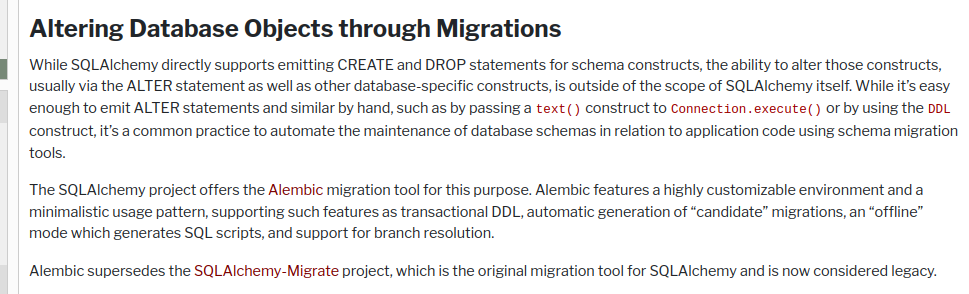

Podemos hacerlo utilizando Alembic o utilizando queries de SQL

**Proyecto 3**: Replicar este proceso utilizando Alembic

In [27]:
from sqlalchemy import create_engine, Column, Integer, String, Float, text
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import declarative_base

In [31]:

engine = start_engine(echo=False)
Session = sessionmaker(bind=engine)
session = Session()

Base = declarative_base()

class Student(Base):
    __tablename__ = 'students'
    cu = Column(Integer, primary_key=True)
    nombre = Column(String)
    apellido = Column(String)
    grade = Column(Float)
if False:
    # Ejecuta una sentencia ALTER TABLE para agregar la columna grade
    session.execute(text('ALTER TABLE students ADD COLUMN grade FLOAT;'))
    session.commit()



In [32]:
s2 =  Student(cu=4, nombre = 'Mikasa', apellido='Akerman', grade=9.0)

# add the students to the session
session.add_all([s2])

# commit the changes to the database
try:
    session.commit()
except IntegrityError:
    session.rollback()
    print('IntegrityError: Duplicate key value')

IntegrityError: Duplicate key value


In [40]:
glipse_tabla('students')

(1, 'Hange', 'Zoe', None)
(2, 'Eren', 'Yeager', None)
(3, 'Armin', 'Arlert', None)
(4, 'Mikasa', 'Akerman', 9.0)


Que pasa si intentamos hacer una transaccion que nos dara error? Se hara completa o parcial?

In [34]:
s2 =  Student(cu=4, nombre = 'Mikasa', apellido='Akerman', grade=9.0)
s3 =  Student(cu=5, nombre = 'Erwin', apellido='Danchou', grade=10.0)

# add the students to the session
session.add_all([s2])

# commit the changes to the database
try:
    session.commit()
except IntegrityError:
    session.rollback()
    print('IntegrityError: Duplicate key value')

IntegrityError: Duplicate key value


In [42]:
glipse_tabla('students')

(1, 'Hange', 'Zoe', None)
(2, 'Eren', 'Yeager', None)
(3, 'Armin', 'Arlert', None)
(4, 'Mikasa', 'Akerman', 9.0)


Al reves? 

In [43]:
s3 =  Student(cu=5, nombre = 'Erwin', apellido='Danchou', grade=10.0)
s2 =  Student(cu=4, nombre = 'Mikasa', apellido='Akerman', grade=9.0)

# add the students to the session
session.add_all([s2])

# commit the changes to the database
try:
    session.commit()
except IntegrityError:
    session.rollback()
    print('IntegrityError: Duplicate key value')

IntegrityError: Duplicate key value


In [50]:
glipse_tabla('students')

(1, 'Hange', 'Zoe', None)
(2, 'Eren', 'Yeager', None)
(3, 'Armin', 'Arlert', None)
(4, 'Mikasa', 'Akerman', 9.0)


Este estilo de transacciones son atomicas, en el sentido que o se ejecutan todas de manera exitosa o se ejecuta ninguna. Deben tratar de que sus flujos de datos sea atomicos en la medida de lo posible.

In [46]:
from typing import Union, List

Crearemos una funcion para agregar estudiantes a la tabla `Students`, sin embargo no pasaremos el la `session` ni el `engine`. Pero, usaremos el que ya existe en el notebook lo cual es mala practica. Tambien pasar constantemente  estos objetos puede volverse complicado. 

Como parte del **proyecto 3** deberan crear un objeto que contenga estas funcionalidades.

In [49]:
def agregar_estudiantes(s:Union[Student, List[Student]]):
    # add the students to the session
    if not isinstance(s, list):
        s = [s]
    session.add_all(s)
    # commit the changes to the database
    try:
        session.commit()
    except IntegrityError:
        session.rollback()
        print('IntegrityError: Duplicate key value')

In [51]:
#s =  Student(cu=5, nombre = 'Erwin', apellido='Danchou', grade=10.0)
#agregar_estudiantes(s)

In [52]:
glipse_tabla('students')

(1, 'Hange', 'Zoe', None)
(2, 'Eren', 'Yeager', None)
(3, 'Armin', 'Arlert', None)
(4, 'Mikasa', 'Akerman', 9.0)


Observa que pasa con las observaciones que no tienen ese campo, se convierten en `None`

Este nuevo objeto/tabla modificado debe permanecer en nuestro codigo para futuras manipulaciones, pues define a nuestra base. En general es buena practica mantener estas tablas/objetos en scripts separados, e importarlas a los scripts.

# Consultar registro Especifico

In [63]:
def create_session(echo:bool=False):
    engine = start_engine(echo=echo)
    Session = sessionmaker(bind=engine)
    session = Session()
    
    return session

In [64]:
# Crea una instancia de sesión
session = create_session()

# Consulta el estudiante con CU igual a 1
student = session.query(Student).filter_by(cu=1).first()

# Imprime el estudiante
print(f"CU: {student.cu}, Nombre: {student.nombre}, Apellido: {student.apellido}, Grade: {student.grade}")

# Cierra la sesión
session.close()

CU: 1, Nombre: Hange, Apellido: Zoe, Grade: None


# Modificar campo especifico

In [65]:
# Crea una instancia de sesión
session = create_session()
# Consulta el estudiante con CU igual a 1
student = session.query(Student).filter_by(cu=1).first()

# Actualiza el grade del estudiante
student.grade = 11.0

# Guarda los cambios en la base de datos
session.commit()

# Cierra la sesión
session.close()


In [66]:
glipse_tabla('students')

(2, 'Eren', 'Yeager', None)
(3, 'Armin', 'Arlert', None)
(4, 'Mikasa', 'Akerman', 9.0)
(1, 'Hange', 'Zoe', 11.0)


# Eliminar Observaciones

In [59]:
from sqlalchemy.orm.exc import NoResultFound
session = create_session()
try:
    cu_a_eliminar = 5 # reemplazar por el valor de 'cu' a eliminar
    student_a_eliminar = session.query(Student).filter(Student.cu == 5).one()
    session.delete(student_a_eliminar)
    session.commit()
except NoResultFound:
    session.rollback()
    print('NoResultFound: No existe esa entrada')

NoResultFound: No existe esa entrada


# Consultar por orden

In [67]:
# Crea una instancia de sesión
session = create_session()
# Consulta todos los estudiantes ordenados por apellido
students = session.query(Student).order_by(Student.apellido).all()

# Imprime los estudiantes
for student in students:
    print(f"CU: {student.cu}, Nombre: {student.nombre}, Apellido: {student.apellido}, Grade: {student.grade}")

# Cierra la sesión
session.close()

CU: 4, Nombre: Mikasa, Apellido: Akerman, Grade: 9.0
CU: 3, Nombre: Armin, Apellido: Arlert, Grade: None
CU: 2, Nombre: Eren, Apellido: Yeager, Grade: None
CU: 1, Nombre: Hange, Apellido: Zoe, Grade: 11.0


# Consultar por condicionales

Nota como el valor `None` no es comparable con otros numeros

In [69]:
# Crea una instancia de sesión
session = create_session()

# Consulta los estudiantes con grade mayor a 4.5
students = session.query(Student).filter(Student.grade > 4.5).all()

# Imprime los estudiantes
for student in students:
    print(f"CU: {student.cu}, Nombre: {student.nombre}, Apellido: {student.apellido}, Grade: {student.grade}")

# Cierra la sesión
session.close()

CU: 4, Nombre: Mikasa, Apellido: Akerman, Grade: 9.0
CU: 1, Nombre: Hange, Apellido: Zoe, Grade: 11.0


## Encadenar Condicionales

In [88]:
# Crea una instancia de sesión
session = create_session()

# Recupera los estudiantes con grade mayor a 5.0 y nombre igual a "Juan"
students = session.query(Student).filter(Student.grade > 5.0).filter(Student.apellido == "Akerman").all()

# Imprime los estudiantes
for student in students:
    print(f"Nombre: {student.nombre}, Apellido: {student.apellido}, Grade: {student.grade}")

# Cierra la sesión
session.close()


Nombre: Mikasa, Apellido: Akerman, Grade: 10.0
Nombre: Levi, Apellido: Akerman, Grade: 11.0


In [93]:
from sqlalchemy import or_
# Crea una instancia de sesión
session = create_session()

# Recupera los estudiantes con grade mayor a 5.0 o apellido igual a "Pérez"
students = session.query(Student).filter(or_(Student.grade > 7.0, Student.nombre == "Hange")).all()

# Imprime los estudiantes
for student in students:
    print(f"Nombre: {student.nombre}, Apellido: {student.apellido}, Grade: {student.grade}")

# Cierra la sesión
session.close()


Nombre: Hange, Apellido: Zoe, Grade: 12.0
Nombre: Mikasa, Apellido: Akerman, Grade: 10.0
Nombre: Levi, Apellido: Akerman, Grade: 11.0


In [94]:
from sqlalchemy import or_, and_
# Crea una instancia de sesión
session = create_session()

# Recupera los estudiantes con grade mayor a 5.0 o apellido igual a "Pérez"
students = session.query(Student).filter(or_(Student.apellido == 'Akerman', and_(Student.grade == None, Student.apellido != None))).all()

# Imprime los estudiantes
for student in students:
    print(f"Nombre: {student.nombre}, Apellido: {student.apellido}, Grade: {student.grade}")

# Cierra la sesión
session.close()


Nombre: Eren, Apellido: Yeager, Grade: None
Nombre: Armin, Apellido: Arlert, Grade: None
Nombre: Mikasa, Apellido: Akerman, Grade: 10.0
Nombre: Levi, Apellido: Akerman, Grade: 11.0


# Group by

In [70]:
s =  Student(cu=5, nombre = 'Levi', apellido='Akerman', grade=10.0)
agregar_estudiantes(s)

In [81]:
from sqlalchemy import func
# Crea una instancia de sesión
session = create_session()

# Consulta la cantidad de estudiantes por grade
result = session.query(Student.grade, func.count(Student.cu)).group_by(Student.grade).all()

# Imprime la cantidad de estudiantes por grade
for grade, count in result:
    print(f"Grade {grade}: {count} estudiantes")

# Cierra la sesión
session.close()

Grade None: 2 estudiantes
Grade 10.0: 1 estudiantes
Grade 11.0: 1 estudiantes
Grade 9.0: 1 estudiantes


In [86]:
from sqlalchemy import func
# Crea una instancia de sesión
session = create_session()

# Consulta la cantidad de estudiantes por grade
result = session.query(Student.apellido, func.count(Student.cu)).group_by(Student.apellido).all()

# Imprime la cantidad de estudiantes por grade
for apellido, count in result:
    print(f"Apellido {apellido}: {count} estudiantes")

# Cierra la sesión
session.close()

Apellido Akerman: 2 estudiantes
Apellido Yeager: 1 estudiantes
Apellido Arlert: 1 estudiantes
Apellido Zoe: 1 estudiantes


# Modificar una columna dado un criterio

In [87]:
# Crea una instancia de sesión
session = create_session()

# Recupera los estudiantes con grade mayor a 5.0
students = session.query(Student).filter(Student.grade > 5.0).all()

# Actualiza el grade de cada estudiante
for student in students:
    student.grade = student.grade + 1.0

# Confirma los cambios
session.commit()

# Cierra la sesión
session.close()
glipse_tabla('students')

(2, 'Eren', 'Yeager', None)
(3, 'Armin', 'Arlert', None)
(1, 'Hange', 'Zoe', 12.0)
(4, 'Mikasa', 'Akerman', 10.0)
(5, 'Levi', 'Akerman', 11.0)


In [ ]:
# # Crea una instancia de sesión
# session = create_session()

# # Recupera los estudiantes con grade mayor a 5.0
# students = session.query(Student).filter(Student.grade == None).all()

# # Actualiza el grade de cada estudiante
# for student in students:
#     student.grade = 0.0

# # Confirma los cambios
# session.commit()

# # Cierra la sesión
# session.close()
# glipse_tabla('students')

# Copiar tabla

In [96]:
from sqlalchemy import Column, Float, Integer, String, create_engine
from sqlalchemy.orm import declarative_base

# Crea una instancia de motor de base de datos
engine = start_engine(False)

# Define la clase base para las tablas
Base = declarative_base()

# Define la clase de la tabla nueva "students_copy"
class StudentCopy(Base):
    __tablename__ = "students_copy"
    cu = Column(Integer, primary_key=True)
    nombre = Column(String)
    apellido = Column(String)
    grade2 = Column(Float)

# Crea las tablas en la base de datos
Base.metadata.create_all(engine)


In [98]:
# Inserta los resultados en la tabla nueva
for student in students:
    student_copy = StudentCopy(
        cu=student.cu,
        nombre=student.nombre,
        apellido=student.apellido,
        grade2=student.grade
    )
    session.add(student_copy)

# Confirma los cambios en la base de datos
session.commit()

# Cierra la sesión de base de datos
session.close()


In [99]:
glipse_tabla('students_copy')

(2, 'Eren', 'Yeager', None)
(3, 'Armin', 'Arlert', None)
(4, 'Mikasa', 'Akerman', 10.0)
(5, 'Levi', 'Akerman', 11.0)
